In [124]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (5,5)

In [125]:
# Gathering data
url = 'https://raw.githubusercontent.com/tugrulhkarabulut/K-Means-Clustering/refs/heads/master/example_datasets/Mall_Customers.csv'
df = pd.read_csv(url, index_col=0)
data = {i: (int(df['Annual Income (k$)'][i]), int(df['Spending Score (1-100)'][i])) for i in range(1,len(df)+1)}
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Text(0, 0.5, 'Spending Score (1-100)')

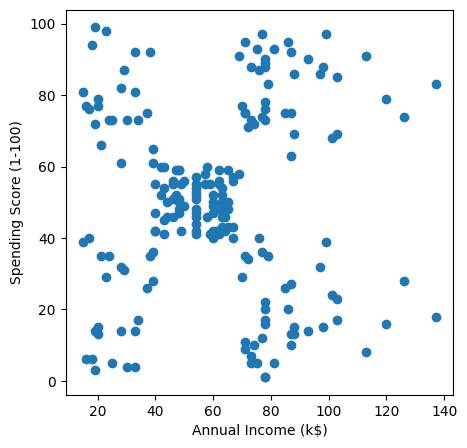

In [126]:
# Plotting data
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

#### **Mathematical Model**

#### Notation

1. Sets
- $i \in I$ $:$ set representing the number of data points
- $k \in k$ $:$ set representing the number of clusters
2. Variables
- $U_{ik}$ $:$ binary variable determining whether data point $i$ is part of cluster $k$
- $x_{k}$ $:$ real variable determining the x coordinate of cluster $k$
- $y_{k}$ $:$ real variable determining the y coordinate of cluster $k$
3. Parameters
- $data_{i}$ $:$ list of data points given

#### Formulation

1. **Objective** \
Our objective is to minimize the within-cluster sum of squares. We gather the sum of squares between the euclidean distance of each data point and cluster centroid, and multiply by the binary variable $U_{ik}$ to ensure that only the cluster containing the data point is used.
$$
\min \sum_{i = 1}^{I} \sum_{k=1}^{K}  U_{ik} * \sqrt{(data_{i0} - x_{i})^2 + (data_{i1} - y_{i})^2}
$$

2. **Constraints**

\begin{align}
\sum_{k = 1}^{K} U_{ik} &= 1 \quad \forall i \in I\\
U_{ik} &\in \{0, 1\} \quad \forall i \in I, k \in K \\
x_{k},y_{k} &\in \mathbb{R} \quad \forall k \in K
\end{align}

- Constraint (1) ensures that each data point is part of a cluster.
- Constraints (2) and (3) define U and x,y variables as binary and real variables, respectively.


In [127]:
def kmeans(data, k):
    global model
    model = ConcreteModel()

    # Number of data points
    model.I = RangeSet(len(data))

    # Number of cluster
    model.K = RangeSet(k)

    # Cluster centroids
    model.x = Var(model.K, bounds = (min(df['Annual Income (k$)']), max(df['Annual Income (k$)'])), within = NonNegativeReals)
    model.y = Var(model.K, bounds = (min(df['Spending Score (1-100)']), max(df['Spending Score (1-100)'])), within = NonNegativeReals)

    # Binary decision if data point is part of cluster
    model.U = Var(model.I, model.K, within = Binary)

    # Each data point has to be part of a cluster
    def con1(model,i):
        return sum(model.U[i,k] for k in model.K) == 1
    model.c1 = Constraint(model.I, rule = con1)

    # Minimize within-cluster sums of squares
    def obj(model):
        return sum(model.U[i,k]*sqrt((data[i][0] - model.x[k])**2 + (data[i][1] - model.y[k])**2) for i in model.I for k in model.K)
    model.obj = Objective(rule = obj)

    # Solve model
    opt = SolverFactory('ipopt')
    result = opt.solve(model)

    if (result.solver.status == SolverStatus.ok) and \
        (result.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        print('Solution is Optimal')
    elif (result.solver.termination_condition == TerminationCondition.infeasible):
        # Do something when model in infeasible
        print('Solution is Infeasible')
    else:
            # Something else is wrong
        print("Solver Status:",  result.solver.status)

    # Solve time
    print('Solve Time: ', result.solver.wallclock_time)

In [128]:
# Running model
kmeans(data,5)

Solution is Optimal
Solve Time:  <undefined>


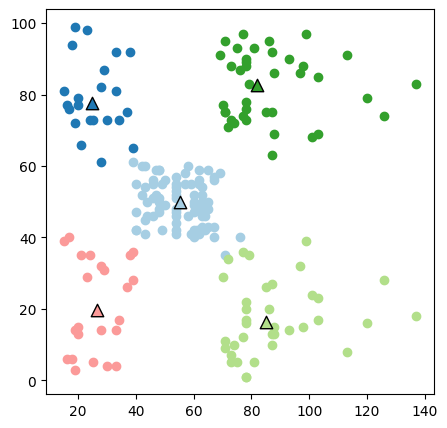

In [129]:
# Plotting solution
color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

for i in model.I:
    for k in model.K:
        if model.U.extract_values()[i,k] == 1:
            c = color[k-1]
    plt.scatter(*data[i], c=c )

for k in model.K:
    plt.scatter(value(model.x[k]),value(model.y[k]), c= color[k-1], marker='^', s = 80,edgecolor="k", linewidths=1)

Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>
Solution is Optimal
Solve Time:  <undefined>


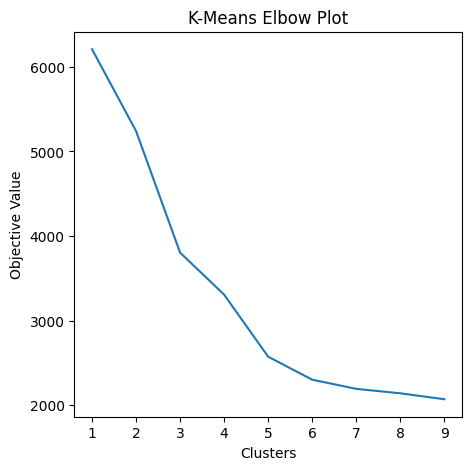

In [130]:
# Elbow plot
obj = []
for i in RangeSet(9):
    kmeans(data,i);
    obj.append(value(model.obj))

plt.plot(RangeSet(9),obj)
plt.title('K-Means Elbow Plot');
plt.xlabel('Clusters');
plt.ylabel('Objective Value');